# 模型文件地址
    
    https://github.com/PaddlePaddle/models/tree/develop/PaddleCV/image_classification
    
    wget http://paddle-imagenet-models-name.bj.bcebos.com/AlexNet_pretrained.tar
    tar -xvf AlexNet_pretrained.tar
    
# 初始化环境

    pip install opencv-python
    pip install paddlepaddle==1.5
    
    

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import cv2
import time
import sys
import math
import numpy as np
import argparse
import functools

import paddle
import paddle.fluid as fluid

#绘图函数
import matplotlib
#服务器环境设置
import matplotlib.pyplot as plt


#加载自定义文件
#from sdk.resnet import ResNet50
from sdk.alexnet import AlexNet
from sdk.attack_pp import *


# 创建对抗样本相关的损失函数和标签并加载模型

In [2]:
#http://www.paddlepaddle.org.cn/documentation/docs/zh/1.5/user_guides/howto/prepare_data/index_cn.html

class_dim=1000
image_shape=[3,224,224]
model_name="alexnet"
use_gpu=False
pretrained_model="AlexNet_pretrained"
TOPK=3

adv_program=fluid.Program()

#完成初始化
with fluid.program_guard(adv_program):
    input_layer = fluid.layers.data(name='image', shape=image_shape, dtype='float32')
    #设置为可以计算梯度
    input_layer.stop_gradient=False

    # model definition
    model = AlexNet()
    out = model.net(input=input_layer, class_dim=class_dim)
    out = fluid.layers.softmax(out)

    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
    exe = fluid.Executor(place)
    exe.run(fluid.default_startup_program())

    #记载模型参数
    fluid.io.load_persistables(exe, pretrained_model)
    
#设置adv_program的BN层状态
init_prog(adv_program)      
    
    
#创建测试用评估模式
eval_program = adv_program.clone(for_test=True)

#定义梯度
with fluid.program_guard(adv_program):
    label = fluid.layers.data(name="label", shape=[1] ,dtype='int64')
    loss = fluid.layers.cross_entropy(input=out, label=label)
    #http://www.paddlepaddle.org.cn/documentation/docs/zh/1.5/api_cn/backward_cn.html
    gradients = fluid.backward.gradients(targets=loss, inputs=[input_layer])[0]

  

# 预测原始图片

In [3]:
img_path = "mug227.png"

img=process_img(img_path)

fetch_list = [out.name]

print(img.shape)

result = exe.run(eval_program,
                 fetch_list=fetch_list,
                 feed={ 'image':img })
result = result[0][0]

pred_label = np.argsort(result)[::-1][:TOPK]
print("Test-score: {0}, class {1}".format(result[pred_label], pred_label))
sys.stdout.flush()


o_img=tensor2img(img)


(1, 3, 224, 224)
Test-score: [0.45799536 0.25545135 0.06149882], class [967 504 849]


# 调用FGSM算法 无定向攻击

Non-Targeted attack target_label=o_label=967
Test-score: [0.31113183 0.24319546 0.18382514], class [849 443 721]
l0=98.06082589285714% l2=4.278867134226704 linf=15.0


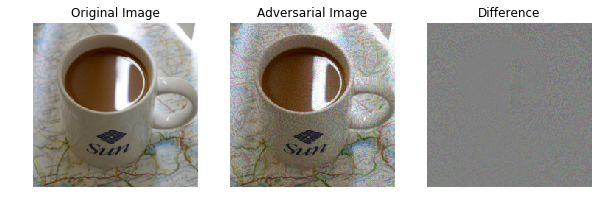

In [4]:
img_path = "mug227.png"
img=process_img(img_path)

#生成对抗样本
#step_size控制了扰动的大小
adv=FGSM(adv_program=adv_program,eval_program=eval_program,gradients=gradients,o=img,
         input_layer=input_layer,output_layer=out,step_size=64.0/256.0,epsilon=16.0/256,isTarget=False,target_label=0)

    
result = exe.run(eval_program,
                 fetch_list=fetch_list,
                 feed={ 'image':adv })
result = result[0][0]

pred_label = np.argsort(result)[::-1][:TOPK]

print("Test-score: {0}, class {1}".format(result[pred_label], pred_label))
sys.stdout.flush()

adv_img=tensor2img(adv)

show_images_diff(o_img,adv_img)

# 演示不同$l_{inf}$约束下FGSM无定向攻击的效果

Non-Targeted attack target_label=o_label=967
Test-score: [0.28671736 0.27901718 0.17945941], class [725 504 849] epsilon=0.03125
l0=97.0696481717687% l2=2.17062798307974 linf=8.0


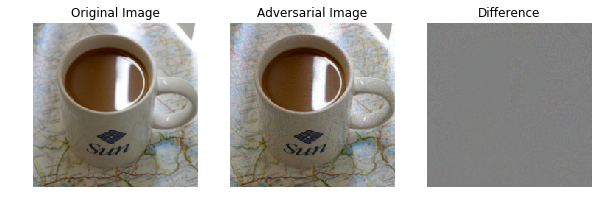

Non-Targeted attack target_label=o_label=967
Test-score: [0.66826195 0.20178849 0.037615  ], class [849 725 443] epsilon=0.0625
l0=98.07610544217687% l2=4.312395619773922 linf=16.0


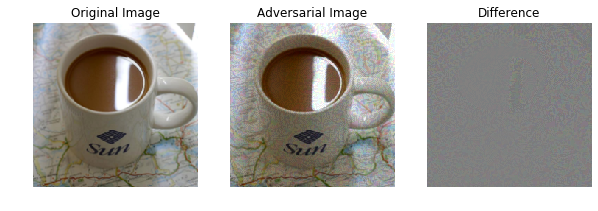

Non-Targeted attack target_label=o_label=967
Test-score: [0.6655097  0.15106912 0.05581865], class [721 849 748] epsilon=0.125
l0=98.36309523809524% l2=8.507690341626319 linf=29.0


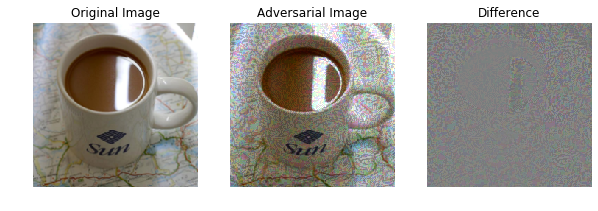

Non-Targeted attack target_label=o_label=967
Test-score: [0.42999613 0.21337958 0.13789412], class [721 806 849] epsilon=0.25
l0=98.75239158163265% l2=12.950914685951702 linf=29.0


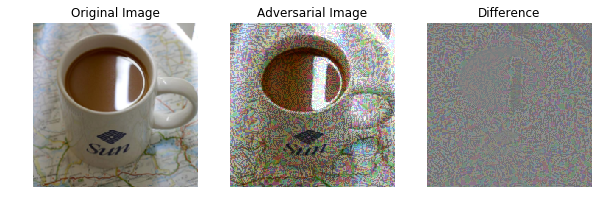

In [5]:
img_path = "mug227.png"
img=process_img(img_path)

for epsilon in [8.0/256,16.0/256,32.0/256,64.0/256]:

    #生成对抗样本
    #step_size控制了扰动的大小
    adv=FGSM(adv_program=adv_program,eval_program=eval_program,gradients=gradients,o=img,
             input_layer=input_layer,output_layer=out,step_size=128.0/256.0,epsilon=epsilon,isTarget=False,target_label=0)


    result = exe.run(eval_program,
                     fetch_list=fetch_list,
                     feed={ 'image':adv })
    result = result[0][0]

    pred_label = np.argsort(result)[::-1][:TOPK]

    print("Test-score: {0}, class {1} epsilon={2}".format(result[pred_label], pred_label,epsilon))
    sys.stdout.flush()

    adv_img=tensor2img(adv)

    show_images_diff(o_img,adv_img)

# 调用FGSM算法 定向攻击

Targeted attack target_label=443 o_label=967
Test-score: [0.30883875 0.21493943 0.09011442], class [443 721 506]
l0=98.72515412414965% l2=7.006686816369534 linf=15.0


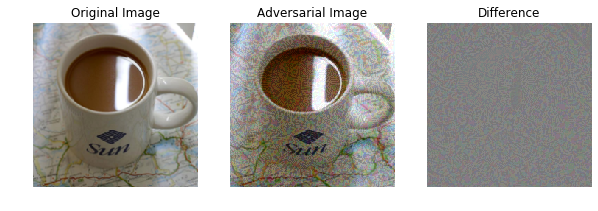

In [6]:
img_path = "mug227.png"
img=process_img(img_path)

#生成对抗样本
adv=FGSM(adv_program=adv_program,eval_program=eval_program,gradients=gradients,o=img,
         input_layer=input_layer,output_layer=out,step_size=64.0/256.0,epsilon=64.0/256,isTarget=True,target_label=443)

    
result = exe.run(eval_program,
                 fetch_list=fetch_list,
                 feed={ 'image':adv })
result = result[0][0]

pred_label = np.argsort(result)[::-1][:TOPK]

print("Test-score: {0}, class {1}".format(result[pred_label], pred_label))
sys.stdout.flush()

adv_img=tensor2img(adv)

#展示原始图片和对抗样本的差异
show_images_diff(o_img,adv_img)

# 演示不同$l_{inf}$约束下FGSM定向攻击的效果

Targeted attack target_label=443 o_label=967
Test-score: [0.9811755  0.00377552 0.00215578], class [443 516 529] epsilon=0.03125
l0=97.05835459183673% l2=2.1680438237752244 linf=8.0


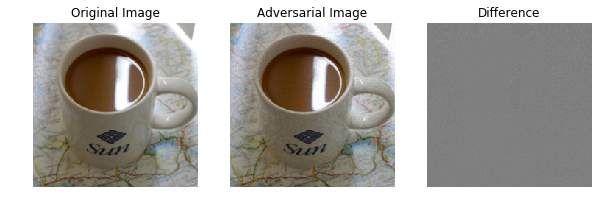

Targeted attack target_label=443 o_label=967
Test-score: [0.9790854  0.00519307 0.00501608], class [443 721 748] epsilon=0.0625
l0=98.05750425170068% l2=4.274447467237562 linf=15.0


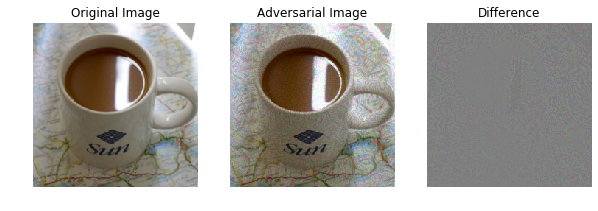

Targeted attack target_label=443 o_label=967
Test-score: [0.8614641  0.06177081 0.01821865], class [443 721 748] epsilon=0.125
l0=98.34980867346938% l2=6.451019411578894 linf=15.0


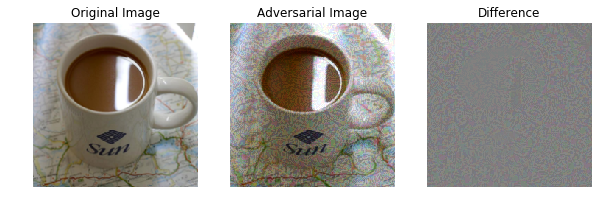

Targeted attack target_label=443 o_label=967
Test-score: [0.66873085 0.078866   0.03555763], class [443 721 748] epsilon=0.25
l0=98.69326636904762% l2=7.0055816437473055 linf=15.0


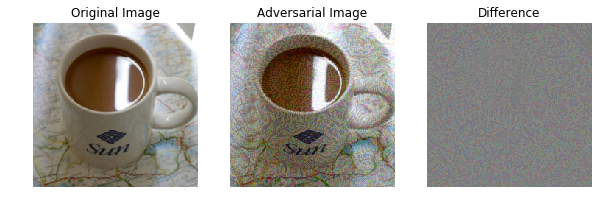

In [7]:
img_path = "mug227.png"
img=process_img(img_path)

for epsilon in [8.0/256,16.0/256,32.0/256,64.0/256]:

    #生成对抗样本
    #step_size控制了扰动的大小
    adv=FGSM(adv_program=adv_program,eval_program=eval_program,gradients=gradients,o=img,
             input_layer=input_layer,output_layer=out,step_size=64.0/256.0,epsilon=epsilon,isTarget=True,target_label=443)


    result = exe.run(eval_program,
                     fetch_list=fetch_list,
                     feed={ 'image':adv })
    result = result[0][0]

    pred_label = np.argsort(result)[::-1][:TOPK]

    print("Test-score: {0}, class {1} epsilon={2}".format(result[pred_label], pred_label,epsilon))
    sys.stdout.flush()

    adv_img=tensor2img(adv)

    show_images_diff(o_img,adv_img)

# 调用PGD算法 无定向攻击

Non-Targeted attack target_label=o_label=967
Test-score: [9.9836463e-01 1.6315877e-03 3.7019558e-06], class [431 516 529]
l0=89.30630846088435% l2=1.7426151497738547 linf=9.0


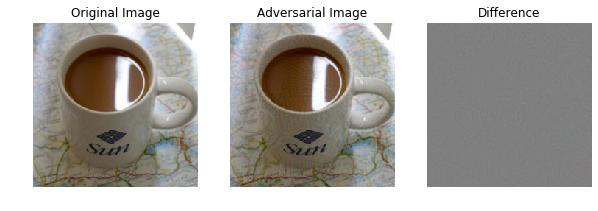

In [8]:
img_path = "mug227.png"
img=process_img(img_path)

#生成对抗样本
#step_size控制了扰动的大小
adv=PGD(adv_program=adv_program,eval_program=eval_program,gradients=gradients,o=img,
         input_layer=input_layer,output_layer=out,step_size=2.0/256.0,epsilon=16.0/256,iteration=20,isTarget=False,target_label=0)

    
result = exe.run(eval_program,
                 fetch_list=fetch_list,
                 feed={ 'image':adv })
result = result[0][0]

pred_label = np.argsort(result)[::-1][:TOPK]

print("Test-score: {0}, class {1}".format(result[pred_label], pred_label))
sys.stdout.flush()

adv_img=tensor2img(adv)

show_images_diff(o_img,adv_img)

# 调用PGD算法 定向攻击

Targeted attack target_label=968 o_label=967
Test-score: [9.9446577e-01 2.5836958e-03 9.2741387e-04], class [968 504 725]
l0=70.42942176870748% l2=0.8662632321094366 linf=5.0


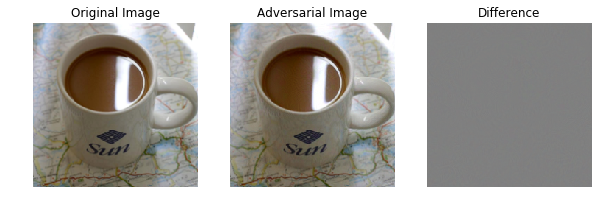

In [9]:
img_path = "mug227.png"
img=process_img(img_path)

#生成对抗样本
#step_size控制了扰动的大小
adv=PGD(adv_program=adv_program,eval_program=eval_program,gradients=gradients,o=img,
         input_layer=input_layer,output_layer=out,step_size=1.0/256.0,epsilon=16.0/256,iteration=20,isTarget=True,target_label=968)

    
result = exe.run(eval_program,
                 fetch_list=fetch_list,
                 feed={ 'image':adv })
result = result[0][0]

pred_label = np.argsort(result)[::-1][:TOPK]

print("Test-score: {0}, class {1}".format(result[pred_label], pred_label))
sys.stdout.flush()

adv_img=tensor2img(adv)

show_images_diff(o_img,adv_img)